In [ ]:
# default_exp complexnet

# complexnet

> CNN whose topology is built by complex networks.

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
cifar10, info = tfds.load(name='food101', with_info=True)

/home/fengwf/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


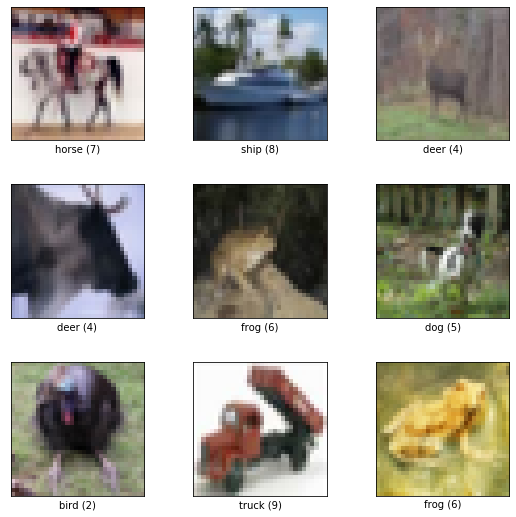

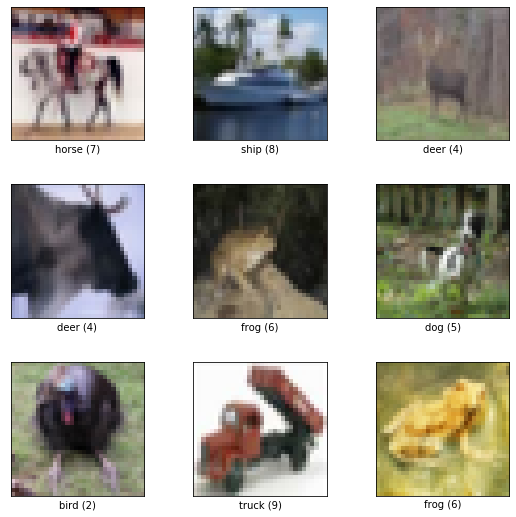

In [ ]:
import matplotlib.pyplot as plt
tfds.show_examples(info, cifar10['train'])

In [ ]:
#export
from hong.imports import *
from hong.graph import *

In [ ]:
#export
def xception_block(inputs, filters, kernel_size, strides):
    if len(inputs) >= 2:
        x = layers.add(inputs)
    else:
        x = inputs[0]
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                               padding='same', use_bias=False, 
                               depthwise_initializer='he_normal',pointwise_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x) #gamma_initializer=keras.initializers.zeros(), moving_variance_initializer='zeros'
    return x

In [ ]:
#export
def complex_net(G, input, filters, kernel_size, stages_nums:tuple):
    n = G.graph['n'] # number of nodes
    assert n == sum(stages_nums) # assert sum of nodes per stage equal to total number of nodes
    layers_nums = []
    for i in range(len(stages_nums)):
        for j in range(sum(stages_nums[:i]), sum(stages_nums[:(i+1)])):
            layers_nums.append(i)
    layers_nums.append(layers_nums[-1]) # add layer id of the final output node
#     print(layers_nums)
    
    results = {}
    for _id in sorted(G.nodes()): # sorted nodes
        if _id == -1: # if the unique input node
            results[-1] = input
            continue
        for pred in G.predecessors(_id): # 
            succs = [pred] #
            for succ in G.successors(pred):
                if succ == _id:
                    break
                succs += [succ]
            real_pred = succs[-1]
            layer_diff = layers_nums[_id] - layers_nums[real_pred]
#             print(_id, pred, real_pred, layer_diff)
            if layer_diff > 0:
                results[pred] = layers.MaxPool2D(pool_size=2**layer_diff)(results[pred])
        inputs = [results[pred] for pred in G.predecessors(_id)]  # get inputs
        if  _id == n:  # if the unique output node, just add them all
             results[_id] = layers.add(inputs)
        else:  # if inner nodes, add them all, then xception op.
            results[_id] = xception_block(inputs, filters=filters, kernel_size=kernel_size, strides=1)
    model = keras.Model(inputs = input, outputs = results[n])
    return model

In [ ]:
input = keras.Input(shape=(32,32,3))

In [ ]:
n = 60
stages_nums = [n//3]*3
G = cascade(n, 0.1)
G = after_DAG(G)

In [ ]:
for _id in sorted(G.nodes()):
    preds = [pred for pred in G.predecessors(_id)]
    succs = [succ for succ in G.successors(_id)]
    print(_id,preds, succs)

-1 [] [0, 1, 2, 3, 7, 8, 10]
0 [-1] [16, 18, 20, 21, 24, 29, 30, 35, 40, 43, 48, 54, 57, 58, 59]
1 [-1] [14, 15, 18, 20, 32, 33, 38, 47, 48, 51, 53, 55]
2 [-1] [4, 13, 16, 27, 29, 38, 39, 42, 44, 49]
3 [-1] [5, 6, 30, 35, 37, 39, 41, 42, 54]
4 [2] [9, 18, 19, 25, 32, 34, 39, 42, 43, 48, 49, 56, 59]
5 [3] [6, 11, 18, 22, 23, 24, 26, 31, 35, 36, 38, 43, 52, 55, 57]
6 [3, 5] [12, 17, 18, 22, 25, 31, 42, 46, 49, 52, 55]
7 [-1] [11, 18, 19, 20, 21, 27, 37, 49]
8 [-1] [12, 13, 15, 18, 24, 25, 27, 35, 43, 49, 51, 55]
9 [4] [17, 19, 25, 26, 33, 35, 38, 41, 42, 46, 47, 51, 55]
10 [-1] [11, 16, 28, 34, 37, 41, 42, 45]
11 [5, 7, 10] [14, 25, 28, 40, 41, 48, 55, 58]
12 [6, 8] [18, 19, 32, 33, 34, 35, 36, 41, 43, 54, 57, 59]
13 [2, 8] [14, 15, 17, 27, 29, 31, 34, 41, 48, 55, 59]
14 [1, 11, 13] [17, 18, 44, 48, 55, 57]
15 [1, 8, 13] [17, 21, 28, 33, 37, 38, 49, 50, 56]
16 [0, 2, 10] [19, 23, 29, 31, 36, 42, 43, 46, 58]
17 [6, 9, 13, 14, 15] [18, 25, 29, 31, 36, 41, 42, 44, 50, 58]
18 [0, 1, 4, 5, 6,

In [ ]:
model = complex_net(G, input, filters=32, kernel_size=3, stages_nums=stages_nums)

In [ ]:
model.summary()

Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
stem_conv (SeparableConv2D)  (None, 32, 32, 32)        155       
_________________________________________________________________
batch_normalization_2014 (Ba (None, 32, 32, 32)        128       
_________________________________________________________________
model_86 (Model)             (None, 8, 8, 64)          584352    
_________________________________________________________________
global_max_pooling2d_13 (Glo (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 585,285
Trainable params: 569,861
Non-trainable params: 15,424
_______________________________________________

In [ ]:
keras.utils.plot_model(model,'first_dag.png', show_layer_names=False)

In [ ]:
#export
def complexnet_1(n, c, stages_nums:tuple, input, filters, kernel_size, num_classes):
    x = layers.SeparableConv2D(filters=filters//2, kernel_size=kernel_size, padding='same', name='stem_conv')(input)
    stem_output = layers.BatchNormalization()(x)
    stage1_input = keras.Input(shape=stem_output.shape[1:])
    G = cascade(n, c=c)
    G = after_DAG(G)
    stage1 = complex_net(G, stage1_input, filters=filters, kernel_size=kernel_size, stages_nums=stages_nums)
    stage1_output = stage1(stem_output)
    
    top = stage1_output
    #top = xception_block(inputs=[stage1_output], filters=1280, kernel_size=kernel_size, strides=1)
    top = layers.GlobalMaxPool2D()(top)
    top = layers.Dense(num_classes, activation='softmax')(top)
    
    model = keras.Model(inputs=input, outputs=top)
    return model

In [ ]:
n = 60*2
c = 0.1
stages_nums = [n//3]*3
filters = 64
kernel_size = 3
model = complexnet_1(n, c, stages_nums, input, filters, kernel_size, num_classes=10)


In [ ]:
#export
def complex_stage(G, input, filters, kernel_size, strides):
    n = G.graph['n'] # number of nodes
    results = {}
    for _id in sorted(G.nodes()): # sorted nodes
        if _id == -1: # if the unique input node
            if strides == 2: # if need downsampling
                results[-1] = layers.MaxPool2D()(input)
            else:
                results[-1] = input
            continue
        inputs = [results[pred] for pred in G.predecessors(_id)]  # get inputs
        if  _id == n:  # if the unique output node, just add them all
             results[_id] = layers.add(inputs)
        else:  # if inner nodes, add them all, then xception op.
            results[_id] = xception_block(inputs, filters=filters, kernel_size=kernel_size, strides=1)
    model = keras.Model(inputs = input, outputs = results[n])
    return model

In [ ]:
model =  complex_stage(G, input, filters=32, kernel_size=3, strides=2)

In [ ]:
#export
def complexnet_2(n, c, input, filters, kernel_size, num_classes):
    x = layers.SeparableConv2D(filters=filters//2, kernel_size=kernel_size, padding='same', name='stem_conv')(input)
    stem_output = layers.BatchNormalization()(x)
    stage1_input = keras.Input(shape=stem_output.shape[1:])
    G = cascade(nodes, c=c)
    G = after_DAG(G)
    stage1 = complex_stage(G, stage1_input, filters=filters, kernel_size=kernel_size, strides=2)
    stage1_output = stage1(stem_output)

    stage2_input = keras.Input(shape=stage1_output.shape[1:])
    G = cascade(nodes, c=c)
    G = after_DAG(G)
    stage2 = complex_stage(G, stage2_input, filters=filters*2, kernel_size=kernel_size, strides=2)
    stage2_output = stage2(stage1_output)

    stage3_input = keras.Input(shape=stage2_output.shape[1:])
    G = cascade(nodes, c=c)
    G = after_DAG(G)
    stage3 = complex_stage(G, stage3_input, filters=filters*4, kernel_size=kernel_size, strides=2)
    stage3_output = stage3(stage2_output)

    #top = xception_block(inputs=[stage3_output], filters=1280, kernel_size=3, strides=1)
    top = stage3_output
    top = layers.GlobalMaxPool2D()(top)
    top = layers.Dense(num_classes)(top)
    model = keras.Model(inputs=input, outputs=top)
    return model

In [ ]:
n = 20
c = 0.1
filters = 64
kernel_size = 3
num_classes = 10
model = complexnet_2(n, c, input, filters, kernel_size, num_classes)


In [ ]:
model.summary()

Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
stem_conv (SeparableConv2D)  (None, 32, 32, 32)        155       
_________________________________________________________________
batch_normalization_1553 (Ba (None, 32, 32, 32)        128       
_________________________________________________________________
model_73 (Model)             (None, 16, 16, 64)        146016    
_________________________________________________________________
model_74 (Model)             (None, 8, 8, 128)         533696    
_________________________________________________________________
model_75 (Model)             (None, 4, 4, 256)         2067968   
_________________________________________________________________
global_max_pooling2d_8 (Glob (None, 256)               0  

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.CategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 311s 8ms/sample - loss: 2.3041 - accuracy: 0.0983 - val_loss: 2.3040 - val_accuracy: 0.0980


In [ ]:
model.outputs

[<tf.Tensor 'dense_2/Identity:0' shape=(None, 10) dtype=float32>]

In [ ]:
m.get_layer('stem_conv')